# Research Design Diagnosis Assignment Starting Point - Count Outcome

J. Nathan Matias ([natematias.com](https://natematias.com)) ([@natematias](https://twitter.com/natematias))
April 2019

Materials related to the Power Analysis Assignment in the 2019 edition of [SOC412](http://natematias.com/courses/soc412/).

This example compares log-transformed linear regression estimators to [Negative Binomial regression](https://stats.idre.ucla.edu/r/dae/negative-binomial-regression/).

In [16]:
options("scipen"=9, "digits"=4)
library(dplyr)
library(MASS)           # contains fitdistr
library(ggplot2)        # for plotting 
library(rlang)
library(tidyverse)
library(viridis)        # colorblind safe palettes
library(DeclareDesign)
library(beepr)
## Installed DeclareDesign 0.13 using the following command:
# install.packages("DeclareDesign", dependencies = TRUE,
#                 repos = c("http://R.declaredesign.org", "https://cloud.r-project.org"))

## DOCUMENTATION AT: https://cran.r-project.org/web/packages/DeclareDesign/DeclareDesign.pdf
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
options(repr.plot.width=7, repr.plot.height=3.5)
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.14.3

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] beepr_1.3            DeclareDesign_0.13.0 estimatr_0.14       
 [4] fabricatr_0.6.0      randomizr_0.16.1     viridis_0.5.1       
 [7] viridisLite_0.3.0    forcats_0.3.0        stringr_1.3.1       
[10] purrr_0.2.5          readr_1.3.1          tidyr_0.8.2         
[13] tibble_2.0.0         tidyverse_1.2.1      rlang_0.3.0.1       
[16] ggplot2_3.1.0        MASS_7.3-51.1        dplyr_0.7.8         

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.0         lubridate_1.7.4    lattice_0

### Utility Methods

In [2]:
# Return the difference in mu associated with an incidence rate ratio
# from a negative binomial model. This difference can then be used to
# simulate a negative binomial distribution for the effect of a given irr
#                                                                       
#` @param mu The baseline mu in question                               
#` @param irr The incidence rate ratio in question
mu.diff.from.mu.irr <- function(mu, irr){
    mu*(irr-1)
}

# Return the total sum of betas for a
# logistic regression, given a probability
#
#` @param p the probability in question
betas.logit.from.prob <- function(p){
    log(p/(1-p))
}


# Return the total sum of betas for a
# logistic regression, given a probability
#
#` @param Y list of observed Ys
betas.logit.from.mean <- function(Y){
    p = mean(Y)
    log(p/(1-p))
}

# Return the minimum power reported in a diagnosis
# 
#` @param diagnosis
min.diagnosis.power <- function(diagnosis){
    min(diagnosis$diagnosands_df['power'])
}

# Iterate linearly for a certain level of statistical power
# within the constraints of a configuration file
# at a certain sample size increment. Useful for
# illustrating ideas, or for comparing estimators with
# very different statistical power, where the binary search
# will optimize for the worst estimator but not show useful
# indormation about more efficient estimators
#
#` @param config.df The configuration file in question
#` @diagnosis.method The method that conducts a single DeclareDesign diagnosis and returns the diagnosis
#` @iteration.interval when iterating, use this interval between sample sizes

iterate.for.power <- function(config.df, diagnosis.method = diagnose.experiment, 
                             iteration.interval){  
    max.sample.size = config.df$n.max
    min.sample.size = config.df$n.min
    current.sample.size = min.sample.size
    
    iteration.count = ceiling((max.sample.size - min.sample.size) / iteration.interval)

    ## Initialize first iteration
    print(paste("min:", min.sample.size, "max:", max.sample.size, "current:", current.sample.size))
    flush.console()

    ptm = proc.time()
    ddf <- diagnosis.method(current.sample.size, config.df)
    ddf$diagnosands$n <- current.sample.size
    diagnoses.df = ddf$diagnosands
    current.power <- min.diagnosis.power(ddf)
    time.elapsed <- proc.time() -  ptm
    print(paste("     seconds:", as.integer(time.elapsed['elapsed'])))
    
    for(i in seq(1, iteration.count)){
        current.sample.size = current.sample.size + iteration.interval
        print(paste("min:", min.sample.size, "max:", max.sample.size, "current:", current.sample.size))
        flush.console()
    
        ptm = proc.time()
        ## conduct simulations
        ddf <- diagnosis.method(current.sample.size, config.df)
        ddf$diagnosands$n <- current.sample.size
        ## append simulation results to dataframe
        diagnoses.df <- rbind(diagnoses.df, ddf$diagnosands)
        time.elapsed <- proc.time() -  ptm
        print(paste("     seconds:", as.integer(time.elapsed['elapsed'])))
    }
    diagnoses.df
}

# Create a plot of a power search or iteration output
# And save to a file
# Especially useful in cases with multiple DVs or models
#
#` @param diagnoses Dataframe of diagnosis info
#` @param config.df the power analysis config dataframe

plot.power.results <- function(diagnoses, config.df){
    for(estimator_label in unique(diagnoses$estimator_label)){
        estimator.diagnoses <- diagnoses[diagnoses$estimator_label==estimator_label,]
        estimator_min_sample = min(estimator.diagnoses$n[estimator.diagnoses$power>0.8])
        p <- ggplot(data=estimator.diagnoses, aes(n, power)) +
                geom_point(color="coral") +
                xlab("sample size") +
                ylim(0,1) +
                geom_hline(aes(yintercept=0.8), linetype="dashed") +
                theme_light() +
                ggtitle(paste(config.df$pa.label, ": statistical Power for Estimator ", estimator_label, "\n",
                              "Minimum sample: ", estimator_min_sample, sep="")) +
                ggsave(paste("figures/power.analysis.", make.names(estimator_label), ".", config.df$pa.label, ".png", sep=""))
    }
}

# Step One: Analyze Current Dataset to Observe Control Group Characteristics

In this step, we use the `fitdistr` method from the `MASS` library to estimate the parameters of a negative binomial distribution describing the number of newcomer comments and the number of removed newcomer comments per discussion.

In [6]:
observed.df <- read.csv("FILENAME REDACTED")

In [7]:
print("Num Comments")
print(summary(observed.df$num.comments))
nc.dist <- fitdistr(observed.df$num.comments, densfun="negative binomial")
print("Num Comments Removed")
print(summary(observed.df$num.comments.removed))
ncr.dist <- fitdistr(observed.df$num.comments.removed, densfun="negative binomial")

[1] "Num Comments"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       2      40       7    6478 


Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”

[1] "Num Comments Removed"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     0.0     0.0     4.4     1.0  1110.0 


Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”

### Experiment Configuration

In [8]:
example.config <- data.frame(
    pa.label = "example.design",
    n.max = 6100,
    n.min = 100,
    
    NC.mu    = nc.dist$estimate[['mu']],
    NC.theta = nc.dist$estimate[['size']],
    NC.effect.irr = exp(0.1823), # 1.19x increase <- you may decide to adjust this

    NCR.mu    = ncr.dist$estimate[['mu']],
    NCR.theta = ncr.dist$estimate[['size']],
    NCR.effect.irr = exp(-0.105) # 0.9x, a 10% decrease <- you may decide to adjust this
)

In [9]:
diagnose.experiment  <- function( n.size, cdf, sims.count = 500, bootstrap.sims.count = 500){
    design <-   declare_population(N = n.size) +
            declare_potential_outcomes(
                NC_Z_0 = rnegbin(n=N, mu = cdf$NC.mu, 
                                 theta = cdf$NC.theta),
                NC_Z_1 = rnegbin(n=N, mu =  cdf$NC.mu + mu.diff.from.mu.irr(
                                                cdf$NC.mu,
                                                cdf$NC.effect.irr),
                                 theta = cdf$NC.theta),
                NCR_Z_0 = rnegbin(n=N, mu = cdf$NCR.mu, 
                                 theta = cdf$NCR.theta),
                NCR_Z_1 = rnegbin(n=N, mu = cdf$NCR.mu +  mu.diff.from.mu.irr(
                                                cdf$NCR.mu,
                                                cdf$NCR.effect.irr),
                                 theta = cdf$NCR.theta)
            ) +
            declare_assignment(num_arms = 2,
                               conditions = (c("0", "1"))) +
            declare_estimand(ate_NC_1_0  = log(cdf$NC.effect.irr)) +
            declare_estimand(ate_NCR_1_0  = log(cdf$NCR.effect.irr)) +
            declare_reveal(outcome_variables = c("NC", "NCR"))  +
    
            ##
            ## ESTIMATORS FOR NC
            ## 

            ## Estimator: linear regression on the log-transformed outcome variable
            declare_estimator(log1p(NC) ~ Z, estimand="ate_NC_1_0", label="NC.lm.log 1/0") +

            ## Estimator: Negative Binomial Regression
            ## this is how a custom estimator is defined. 
            ## in this case, it runs glm.nb, records the coefficient & test statistics
            ## for the term "Z1" in the summary table, calculates confidence intervalss
            ## and returns the outcome along with confidence intervals
            declare_estimator(handler=tidy_estimator(function(data){
                                  m <- glm.nb(formula = NC ~ Z, data)
                                  out <- subset(tidy(m), term == "Z1")
                                  transform(out,
                                      conf.low = estimate - 1.96*std.error,
                                      conf.high = estimate + 1.96*std.error
                                  )
                              }), estimand="ate_NC_1_0", label="NC.nb 1/0") +

            ##
            ## ESTIMATORS FOR NCR
            ## 
            
            ## Estimator: linear regression on the log-transformed outcome variable
            declare_estimator(log1p(NCR) ~ Z, estimand="ate_NCR_1_0", label="NCR.lm.log 1/0") +

            ## Estimator: Negative Binomial Regression
            declare_estimator(handler=tidy_estimator(function(data){
                                  m <- glm.nb(formula = NCR ~ Z, data)
                                  out <- subset(tidy(m), term == "Z1")
                                  transform(out,
                                      conf.low = estimate - 1.96*std.error,
                                      conf.high = estimate + 1.96*std.error
                                  )
                              }), estimand="ate_NCR_1_0", label="NCR.nb 1/0")
    
    diagnosis <- diagnose_design(design, sims = sims.count, 
                                 bootstrap_sims = bootstrap.sims.count)
    diagnosis
}

# Conduct Power Analysis

In [11]:
interval = 400
power.iterate.df <- iterate.for.power(example.config, 
                                      diagnosis.method=diagnose.experiment, 
                                      iteration.interval = interval)
beep(sound="treasure")

[1] "min: 100 max: 6100 current: 100"
[1] "     seconds: 18"
[1] "min: 100 max: 6100 current: 500"
[1] "     seconds: 23"
[1] "min: 100 max: 6100 current: 900"
[1] "     seconds: 25"
[1] "min: 100 max: 6100 current: 1300"
[1] "     seconds: 27"
[1] "min: 100 max: 6100 current: 1700"
[1] "     seconds: 30"
[1] "min: 100 max: 6100 current: 2100"
[1] "     seconds: 32"
[1] "min: 100 max: 6100 current: 2500"
[1] "     seconds: 34"
[1] "min: 100 max: 6100 current: 2900"
[1] "     seconds: 40"
[1] "min: 100 max: 6100 current: 3300"
[1] "     seconds: 40"
[1] "min: 100 max: 6100 current: 3700"
[1] "     seconds: 44"
[1] "min: 100 max: 6100 current: 4100"
[1] "     seconds: 46"
[1] "min: 100 max: 6100 current: 4500"
[1] "     seconds: 50"
[1] "min: 100 max: 6100 current: 4900"
[1] "     seconds: 52"
[1] "min: 100 max: 6100 current: 5300"
[1] "     seconds: 56"
[1] "min: 100 max: 6100 current: 5700"
[1] "     seconds: 59"
[1] "min: 100 max: 6100 current: 6100"
[1] "     seconds: 63"


### Statistical Power Associated with Estimators

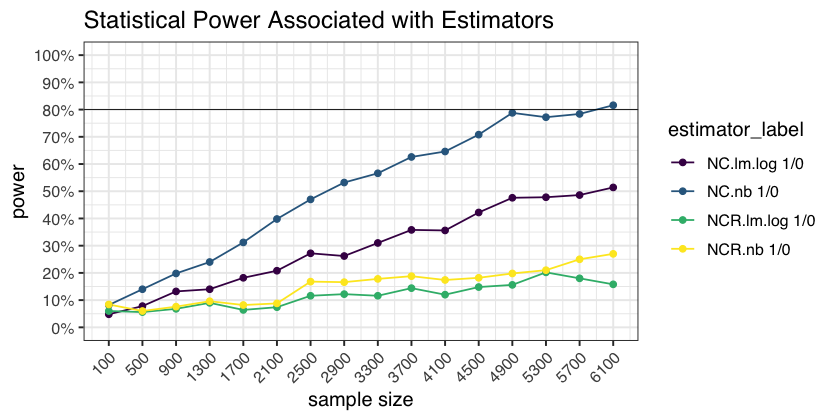

In [12]:
ggplot(power.iterate.df, aes(n, power, color=estimator_label)) +
    ## CHART SUBSTANCE
    geom_line() +
    geom_point() +
    ## LABELS AND COSMETICS
    geom_hline(yintercept=0.8, size=0.25) +
    theme_bw(base_size = 12, base_family = "Helvetica") +
    theme(axis.text.x = element_text(angle=45, hjust = 1)) +
    scale_y_continuous(breaks = seq(0,1,0.1), limits = c(0,1), labels=scales::percent) +
    scale_x_continuous(breaks = seq(example.config$n.min,example.config$n.max,interval)) +
    scale_color_viridis(discrete=TRUE) +
    xlab("sample size") +
    ggtitle("Statistical Power Associated with Estimators")

### Bias Associated with Estimators

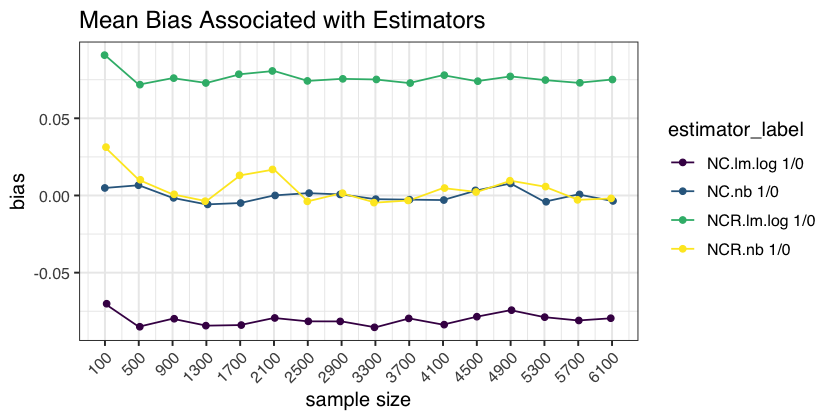

In [13]:
ggplot(power.iterate.df, aes(n, bias, color=estimator_label)) +
    ## CHART SUBSTANCE
    geom_line() +
    geom_jitter(width=20, height=0) +
    ## LABELS AND COSMETICS
    theme_bw(base_size = 12, base_family = "Helvetica") +
    theme(axis.text.x = element_text(angle=45, hjust = 1)) +
    scale_x_continuous(breaks = seq(example.config$n.min,example.config$n.max,interval)) +
    scale_color_viridis(discrete=TRUE) +
    xlab("sample size") +
    ggtitle("Mean Bias Associated with Estimators")

### Confidence Interval Coverage Associated with Estimators

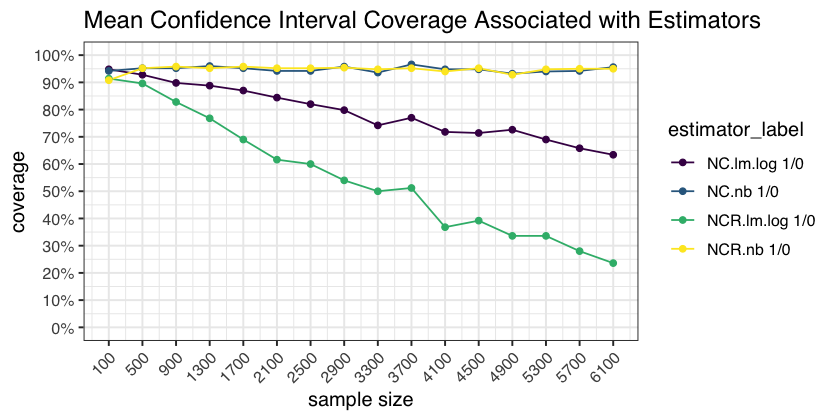

In [14]:
ggplot(power.iterate.df, aes(n, coverage, color=estimator_label)) +
    ## CHART SUBSTANCE
    geom_line() +
    geom_point() +
    ## LABELS AND COSMETICS
    theme_bw(base_size = 12, base_family = "Helvetica") +
    theme(axis.text.x = element_text(angle=45, hjust = 1)) +
    scale_x_continuous(breaks = seq(example.config$n.min,example.config$n.max,interval)) +
    scale_y_continuous(breaks = seq(0,1,0.1), limits = c(0,1), labels=scales::percent) +
    scale_color_viridis(discrete=TRUE) +
    xlab("sample size") +
    ggtitle("Mean Confidence Interval Coverage Associated with Estimators")

### Type S Error Rate Associated with Estimators

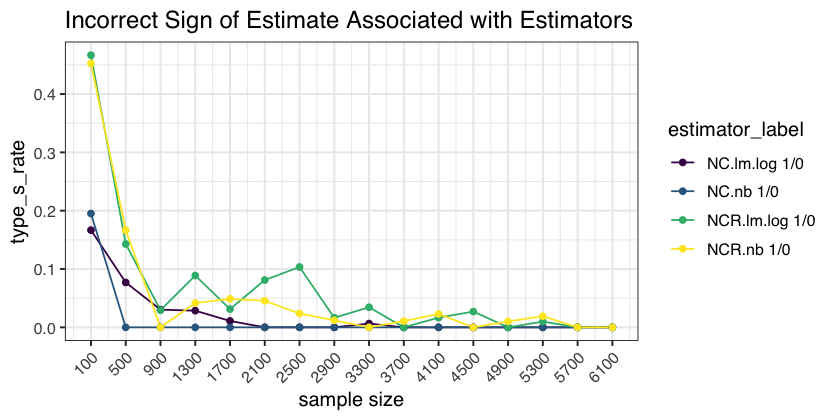

In [15]:
ggplot(power.iterate.df, aes(n, type_s_rate, color=estimator_label)) +
    ## CHART SUBSTANCE
    geom_line() +
    geom_point() +
    ## LABELS AND COSMETICS
    theme_bw(base_size = 12, base_family = "Helvetica") +
    theme(axis.text.x = element_text(angle=45, hjust = 1)) +
    scale_x_continuous(breaks = seq(example.config$n.min,example.config$n.max,interval)) +
    scale_color_viridis(discrete=TRUE) +
    xlab("sample size") +
    ggtitle("Incorrect Sign of Estimate Associated with Estimators")